In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import csv
from tqdm import tqdm
import torch.nn.functional as F

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [80]:
base_path = r'C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\\'

ids_path = 'prepeard_data.csv'
ing_vocab_path = "ingredient_vocab.csv"
rec_vocab_path = "recipie_vocab.csv"

data_len = 2231142

In [81]:
with open(base_path + ing_vocab_path, 'r') as file:
    ingredient_vocab = [t[0] for t in list(csv.reader(file))[1:]]
with open(base_path + rec_vocab_path, 'r') as file:
    recipie_vocab = [t[0] for t in list(csv.reader(file))[1:]]
print(recipie_vocab)

['<UKN>', '<PAD>', '.', ',', 'and', 'the', 'in', 'to', 'a', 'with', 'until', 'add', 'of', 'minutes', 'for', 'or', 'on', 'into', 'heat', 'over', ';', 'mix', 'cook', 'bowl', 'pan', 'stir', 'mixture', '1', 'salt', 'bake', 'at', 'place', 'about', 'water', 'sugar', ')', 'is', '(', 'oven', 'it', 'butter', '2', 'oil', 'large', 'top', 'ingredients', 'combine', 'pour', 'pepper', 'cheese', 'from', 'remove', 'well', 'baking', 'serve', 'then', 'flour', 'cream', 'cover', 'sauce', 'chicken', 'cool', 'together', 'medium', 'all', 'you', 'brown', 'remaining', 'if', 'each', 'cut', 'let', 'boil', 'set', 'sprinkle', 'cup', '5', '3', 'onion', 'are', '1/2', 'milk', 'garlic', '10', 'dough', 'stirring', 'beat', 'small', 'skillet', 'egg', 'simmer', 'dish', ':', 'preheat', 'bring', 'drain', 'put', 'eggs', '4', 'out', 'as', 'juice', '30', 'hot', 'up', 'hours', 'half', 'spread', 'be', 'aside', 'saucepan', 'your', 'when', 'make', 'degrees', '15', '350Â°', 'lightly', 'them', 'smooth', 'an', 'sheet', 'tender', 'meat

In [82]:
rec_input_offset = len(ingredient_vocab)
input_vocab = ingredient_vocab + ["R"+r for r in recipie_vocab] + ["<ING>", "<REC>", "<END>"]
output_vocab = recipie_vocab + ["<END>"]


input_w2id =  {w:i for i,w in  enumerate(input_vocab)}
input_id2w =  {i:w for i,w in  enumerate(input_vocab)}
output_w2id =  {w:i for i,w in  enumerate(output_vocab)}
output_id2w =  {i:w for i,w in  enumerate(output_vocab)}
(output_w2id)["<END>"]

8195

In [83]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Your input sequences
sequences = [
    [torch.tensor([1, 2, 3]), torch.tensor([1, 2])],
    [torch.tensor([4, 5]), torch.tensor([4])],
    [torch.tensor([6, 7, 8, 9]), torch.tensor([6, 7, 8])]
]


padded_sequences = []
for seq in sequences:
    padded_sequences.extend(pad_sequence(seq, batch_first=True, padding_value=0))

padded_sequences = pad_sequence(padded_sequences, batch_first=True, padding_value=0)

y, x = padded_sequences.shape

adjusted_y = y - (y % 2)

# Reshape the tensor
output_tensor = padded_sequences[:adjusted_y, :].view(adjusted_y // 2, 2, x).permute(1,0,2)

# 'output_tensor' now has the desired shape (adjusted_y/2, 2, x)
output_tensor


tensor([[[1, 2, 3, 0],
         [4, 5, 0, 0],
         [6, 7, 8, 9]],

        [[1, 2, 0, 0],
         [4, 0, 0, 0],
         [6, 7, 8, 0]]])

In [84]:


# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_vocab_len, hidden_size, rec_vocab_len, depth):
        super(Generator, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_vocab_len, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=depth, batch_first=True)
        self.l1 = nn.Linear(hidden_size * depth, 10000)
        self.l2 = nn.Linear(10000, 10000)
        self.l3 = nn.Linear(10000, rec_vocab_len)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        rand_source = torch.rand((embedded.shape[0], 1, embedded.shape[2])).to(device)
        #embedded = torch.concat((rand_source, embedded), dim = 1)
        hidden_states, (last_hidden, _) = self.rnn(embedded)
        last_hidden = last_hidden.view(1, -1)
        output1 = self.l1(last_hidden)
        output2 = self.l2(output1)
        logits = self.l3(output2)  # Using only the hidden state at the last time step
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs, hidden_states


# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, rec_vocab_len, hidden_size):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(rec_vocab_len, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, input):
        embedded = self.embedding(input)
        hidden_states, (last_hidden, _) = self.rnn(embedded)
        output = self.fc(last_hidden)
        prob = F.sigmoid(output)
        return prob, hidden_states

In [85]:
class CSVDataLoader:
    def __init__(self, csv_file_path, batch_size, num_rows):
        self.csv_file_path = csv_file_path
        self.batch_size = batch_size
        self.num_rows = num_rows
        self.current_index = 0
        self.file_handle = None
        self.csv_writer = None
        self.headers = None

    def open_csv_file(self):
        self.file_handle = open(self.csv_file_path, 'r', newline='')
        self.csv_writer = csv.reader(self.file_handle)
        # Assuming the first row contains headers
        self.headers = next(self.csv_writer)

    def close_csv_file(self):
        if self.file_handle is not None and not self.file_handle.closed:
            self.file_handle.close()

    def reset(self):
        self.close_csv_file()
        self.open_csv_file()
        self.current_index = 0

    def has_next_batch(self):
        return self.current_index < self.num_rows

    def get_next_batch(self, pad1, pad2, end_toekn):
        ing_batch = [] 
        rec_batch = []
        for _ in range(self.batch_size):
            if not self.has_next_batch():
                break
            ing, rec = next(self.csv_writer)
            ing_batch.append(torch.tensor(eval(ing)).to(device))
            rec_batch.append(torch.tensor(eval(rec) + [end_toekn]).to(device))
            self.current_index += 1
        padded_sequences = []
        

        ing_padded = pad_sequence(ing_batch, batch_first=True, padding_value=pad1)
        rec_padded = pad_sequence(rec_batch, batch_first=True, padding_value=pad2)
        return ing_padded, rec_padded
    
    def batches_left(self):
        return (self.num_rows - self.current_index) // self.batch_size
    
    def __del__(self):
        self.close_csv_file()

In [86]:
import torch

# Tensor with shape (x, 3)
tensor_x3 = torch.tensor([[1, 2, 3], [4, 5, 6]])
a =    torch.tensor([7, 8]).unsqueeze(1)
b =    torch.tensor([9, 10]).unsqueeze(1)

print(tensor_x3.shape, a.shape, b.shape)
# Stack tensors along the second dimension (dimension 1)
result_tensor = torch.cat((tensor_x3, a, b), dim=1)

print(result_tensor)


torch.Size([2, 3]) torch.Size([2, 1]) torch.Size([2, 1])
tensor([[ 1,  2,  3,  7,  9],
        [ 4,  5,  6,  8, 10]])


In [87]:
def patch_batch_input(ings, start, midel, end):
    start_tokens = torch.full((ings.shape[0],), start).unsqueeze(1).to(device)
    midel_tokens = torch.full((ings.shape[0],), midel).unsqueeze(1).to(device)
    end_tokens = torch.full((ings.shape[0],), end).unsqueeze(1).to(device)
    return torch.cat((start_tokens, ings, midel_tokens, end_tokens), dim=1).to(device)

def patch_batch_output(recs, end):
    end_tokens = torch.full((recs.shape[0],), end).unsqueeze(1).to(device)
    return torch.cat((recs, end_tokens), dim=1).to(device)

In [88]:
data_path = r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\prepeard_data.csv"
data_loader = CSVDataLoader(data_path, 32, 2231142)
data_loader.open_csv_file()
d = data_loader.get_next_batch(ingredient_vocab.index("<PAD>"),
                               recipie_vocab.index("<PAD>"), 
                               output_vocab.index("<END>"))
data_loader.close_csv_file()

patch_batch_input(d[0], input_w2id["<ING>"], input_w2id["<REC>"],  input_w2id["<END>"]).shape

torch.Size([32, 81])

In [89]:
a = torch.tensor([1,2,3])
(a[a != 3])

tensor([1, 2])

In [90]:
import torch

# Assuming you have a PyTorch tensor named 'your_tensor'
your_tensor = torch.tensor([50, 100, 75, 100, 200, 100])

# Find indices where values are equal to 100
indices = torch.nonzero(~torch.eq(your_tensor, 100), as_tuple=False).squeeze()

your_tensor[indices] = torch.tensor([1,2,3])
your_tensor


tensor([  1, 100,   2, 100,   3, 100])

In [91]:
your_tensor = torch.tensor([50, 100, 75, 100, 200, 100])
your_tensor[torch.tensor([2,1])]

tensor([ 75, 100])

In [92]:
import torch
import torch.nn.functional as F

# Create a sample tensor
input_tensor = torch.tensor([[1.0, 2.0, 3.0],
                            [3.0, 4.0, 6.0],
                            [71.0, 8.0, 9.0]])

# Apply softmax along rows (dimension 1)
softmax_output = F.softmax(input_tensor, dim=1)

print("Original tensor:")
print(input_tensor)
print("\nSoftmax for each row:")
print(torch.sum(softmax_output, dim=1))


Original tensor:
tensor([[ 1.,  2.,  3.],
        [ 3.,  4.,  6.],
        [71.,  8.,  9.]])

Softmax for each row:
tensor([1.0000, 1.0000, 1.0000])


In [93]:
import torch

# Assuming your matrix is a PyTorch tensor
prob_matrix = torch.tensor([[0.2, 0.3, 0.5],
                           [0.1, 0.6, 0.3],
                           [0.4, 0.2, 0.4]])

# Use torch.multinomial to sample indices for each row
sampled_indices = torch.multinomial(prob_matrix, 1)

print("Sampled Indices:")
print(sampled_indices.squeeze(1))


Sampled Indices:
tensor([0, 1, 1])


In [94]:
a =  torch.tensor([[0.2, 0.3, 0.5],
                           [0.1, 0.6, 0.3],
                           [0.4, 0.2, 0.4]])
i = torch.tensor([1,3,5])

a = torch.concat((a[:,:-1], torch.tensor([1,2,3]).unsqueeze(1), a[:,-1:]), dim = 1)

a

tensor([[0.2000, 0.3000, 1.0000, 0.5000],
        [0.1000, 0.6000, 2.0000, 0.3000],
        [0.4000, 0.2000, 3.0000, 0.4000]])

In [95]:
a =  torch.tensor([[0.2, 0.3, 0.5],
                           [0.1, 0.6, 0.3],
                           [0.4, 0.2, 0.4]])

torch.topk(a, k= 2, dim = 1)

torch.return_types.topk(
values=tensor([[0.5000, 0.3000],
        [0.6000, 0.3000],
        [0.4000, 0.4000]]),
indices=tensor([[2, 1],
        [1, 2],
        [0, 2]]))

In [96]:
def topk_generator(generator, k, b, max_len, stop_token, pad):
    batch_x = b
    rec_start = batch_x.shape[1] - 1
    i = 0
    not_done_indices = torch.arange(batch_x.shape[0]).to(device)
    while i < max_len != 0:
        next_probs, hidden_states = generator(batch_x[not_done_indices])
        topk_value, topk_index = torch.topk(next_probs, k, dim = 1)
        topk_value, topk_index = topk_value.to(device), topk_index.to(device)
        topk_index_index = torch.multinomial(torch.exp(topk_value), 1).squeeze(1).to(device)
        next_tokens = topk_index[torch.arange(topk_index_index.shape[0]), topk_index_index]
        
        done_indices = torch.nonzero(torch.eq(next_tokens, stop_token), as_tuple=False).squeeze().to(device)
        """if done_indices.numel() != 0:
            print(done_indices.shape[0], batch_x.shape[0] - not_done_indices.shape[0])"""
        not_done_indices = not_done_indices[~torch.isin(not_done_indices, done_indices)]
        
        next_tokens_column = torch.full((batch_x.shape[0],), pad).to(device)
        next_tokens_column[not_done_indices] = next_tokens
        next_tokens_column = next_tokens_column.unsqueeze(1)

        batch_x = torch.concat((batch_x[:,:-1], next_tokens_column, batch_x[:,-1:]), dim=1).to(device)
        a = (not_done_indices.shape[0])
        if not_done_indices.shape[0] == 0:
            break
        i +=1
    output_end_tokens = torch.full((batch_x.shape[0],), pad).to(device)
    output_end_tokens[not_done_indices] = stop_token
    output_end_tokens = output_end_tokens.unsqueeze(1)
    batch_x = torch.concat((batch_x[:, :-1], output_end_tokens), dim=1).to(device)
    ings = batch_x[:,:rec_start]
    recs = batch_x[:,rec_start:]
    return recs, (ings, hidden_states)



In [97]:
class Dummy_loader:
    def __init__(self, d) -> None:
        self.d = d

    def reset(self):
        pass
    def open_csv_file(self):
        pass
    def batches_left(self):
        return 1

    def get_next_batch(self, a,b,c):
        return self.d
    

In [98]:
# Hyperparameters
generator_hidden_size = 500
discriminator_hidden_size = 4
#seq_length = 20  # Adjust based on your prompt length
gen_lr  = 0.001
disc_lr = gen_lr
batch_size = 1

k = 1
max_gen_len = 4
epochs = 300

In [99]:
torch.autograd.set_grad_enabled(True)
a = CSVDataLoader(r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\dummy_data.csv", 1, 1)
a.open_csv_file()
pad1 = input_w2id["<PAD>"]
pad2 = input_w2id["R<PAD>"]
end_token = output_w2id["<END>"]
dummy_loader = Dummy_loader(a.get_next_batch(pad1,pad2,end_token))
#data_loader = CSVDataLoader(data_path, batch_size, 2231142)


data_loader = dummy_loader


data_loader.open_csv_file()
# Instantiate Generator and Discriminator
generator = Generator(len(input_vocab), generator_hidden_size, len(output_vocab), 2).to(device)
discriminator = Discriminator(len(output_vocab), discriminator_hidden_size).to(device)
generator.train()

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=gen_lr)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr)

gen_losses = []
real_losses = []
fake_losses = []
avg_real = []
avg_fake = []


for epoch in tqdm(range(epochs)):
    if epoch == 40:
        pass
    data_loader.reset()
    batch_nr = 0
    total_nr_batches = data_loader.batches_left()
    #total_nr_batches =  100
    itr =(range(total_nr_batches))
    for batch_nr in itr:
        # Training the Discriminator
        pad1 = input_w2id["<PAD>"]
        pad2 = input_w2id["R<PAD>"]
        end_token = output_w2id["<END>"]
        real_ingredients, real_batch_y = data_loader.get_next_batch(pad1,pad2, end_token)
        real_batch_x = patch_batch_input(real_ingredients, 
                                        input_w2id["<ING>"],
                                        input_w2id["<REC>"],
                                        input_w2id["<END>"], )
    
        
        generated_recepies, _ = topk_generator(generator, 
                                            k, 
                                            real_batch_x, 
                                            max_gen_len, 
                                            output_w2id["<END>"],
                                            output_w2id["<PAD>"])

        real_labels = torch.ones((batch_size, )).to(device)
        fake_labels = torch.zeros((batch_size, )).to(device)

        disc_optimizer.zero_grad()
        #print(real_batch_y.shape)
        real_output, _ = discriminator(real_batch_y)
        real_output = real_output.squeeze(-1).squeeze(0)
        real_loss = criterion(real_output, real_labels)
        avg_real.append(torch.mean(real_output).item())

        #print(generated_recepies.shape)
        fake_output, _ = discriminator(generated_recepies)
        fake_output = fake_output.squeeze(-1).squeeze(0)
        fake_loss = criterion(fake_output, fake_labels)
        avg_fake.append(torch.mean(fake_output).item())

        disc_loss = real_loss + fake_loss
        if avg_fake[-1] > 0.4:
            disc_loss.backward()
            disc_optimizer.step()
            
            

        # Training the Generator
        gen_optimizer.zero_grad()
        generator.zero_grad()

        fake_output, _ = discriminator(generated_recepies)
        fake_output = fake_output.squeeze(-1).squeeze(0)
        gen_loss = criterion(fake_output, real_labels)
        
        if avg_fake[-1] <= 0.4:
            
            gen_loss.backward()
            #print(gen_loss.item())
            
            gen_optimizer.step()
            
            

        # Print losses
      
        gen_losses.append(gen_loss.item())
        real_losses.append(real_loss.item())
        fake_losses.append(fake_loss.item())

    
            

  0%|          | 0/300 [00:00<?, ?it/s]


RuntimeError: only Tensors of floating point and complex dtype can require gradients

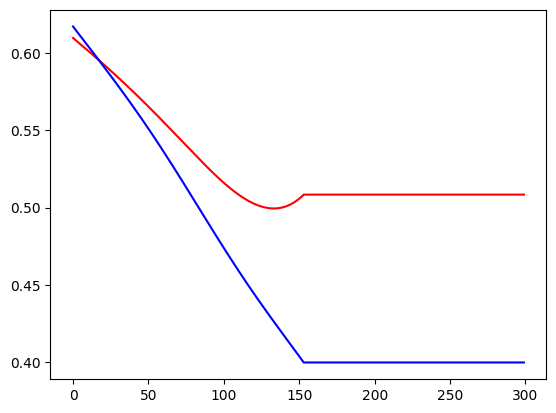

0.3999994695186615

In [ ]:
import matplotlib.pyplot as plt
plt.plot(avg_real, color = "red")
plt.plot(avg_fake, color = "blue")
plt.show()
avg_fake[-1]

In [ ]:
print(gen_losses[-1], real_losses[-1], fake_losses[-1])

0.5130154490470886 0.47091764211654663 0.9130148887634277


In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def encode(prompt, dic):
    return [dic.get(t.lower(),dic["<UKN>"]) for t in word_tokenize(prompt)]

In [ ]:
encode("1. break milk I brew a cool candy", input_w2id)

[0, 2992, 41, 214, 4628, 156, 246, 656]

In [ ]:
def decode(answer, dic):
    return " ".join([dic[i] for i in answer])

In [ ]:
decode(encode("we bake a NLP cake", output_w2id), output_id2w)

'we bake a <UKN> cake'

In [ ]:
def generate(prompt, generator,k, max_len):
    t = torch.tensor(encode(prompt, input_w2id)).unsqueeze(0).to(device)
    batch = patch_batch_input(t,
                              input_w2id["<ING>"],
                              input_w2id["<REC>"],
                              input_w2id["<END>"],)
    answer, _ = topk_generator(generator,k, batch, max_len,  output_w2id["<END>"],output_w2id["<PAD>"])

    return decode([int(i) for i in answer[0][:-1]], output_id2w)

In [ ]:
seed = 1337
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
ing, rec ="1 c. firmly packed brown sugar * 1/2 c. evaporated milk * 1/2 tsp. vanilla * 1/2 c. broken nuts (pecans) * 2 Tbsp. butter or margarine * 3 1/2 c. bite size shredded rice biscuits","In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in vanilla and cereal; mix well. Using 2 teaspoons, drop and shape into 30 clusters on wax paper. Let stand until firm, about 30 minutes."

generator.eval()
with torch.no_grad():
    for i in range(3):
        print((generate(ing, generator, 1, 50)))
print()
print(rec)

just just just just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just
just just just just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just
just just just just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just baller just just just just just

In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. Stir over medium heat until mixture bubbles all over top. Boil and stir 5 minutes more. Take off heat. Stir in van